      Sex  Age  Diabetes duration (y)  Diabetic retinopathy (DR)  Smoking  \
0    Male   57                   10.0                          1        1   
1    Male   50                    8.0                          1        1   
2    Male   53                    8.0                          1        1   
3    Male   52                   20.0                          1        0   
4  Female   56                   12.0                          1        0   

   Drinking  Height(cm)  Weight(kg)  BMI (kg/m2)  SBP (mmHg)   ...  \
0         0       178.0        60.0    18.937003          101  ...   
1         1       172.0        72.5    24.506490          156  ...   
2         0       168.0        62.0    21.967120          105  ...   
3         0       175.0        66.0    21.551020          104  ...   
4         0       159.0        68.8    27.214113          155  ...   

   FBG (mmol/L)  TG（mmoll）  C-peptide (ng/ml）  TC（mmoll）  HDLC（mmoll）  \
0        17.420       1.95               0.

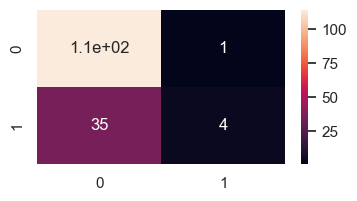

In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import scipy.stats as st
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Read the Excel file from your local disk
df = pd.read_excel('Diabetic_Nephropathy.xlsx')

# Handling missing values in BMI
# df['BMI'].fillna(df['BMI'].mean(), inplace=True)

# # Handling missing values in OGTT using mean
# df['OGTT'].fillna(df['OGTT'].mean(), inplace=True)

# Handle missing values for other columns
# df.fillna(df.mean(), inplace=True)  # Fill missing values with mean for numerical columns
# df.fillna(df.mean(), inplace=True)  # Fill missing values with most frequent value for categorical columns

# df.drop(['Case Number'], inplace=True, axis=1)
# df.reset_index(inplace=True)

# Display the first few rows of the DataFrame
print(df.head())
print("Length of the DataFrame:", len(df))

# classification or regression
target = "Diabetic_nephropathy (DN)"
test_size = 0.2

if (type(df[target][0]) == str) or (type(df[target][0]) == int) or (type(df[target][0]) == np.int16) or (type(df[target][0]) == np.int32) or (type(df[target][0]) == np.int64):
    models_type = 'classification'
else:
    models_type = 'regression'

def label_encoding(old_column):
    le = LabelEncoder()
    le.fit(old_column)
    new_column = le.transform(old_column)
    return new_column

for i in df.columns:
    if type(df[i][0]) == str:
        df[i] = label_encoding(df[i])

y = df[target].values
x = df.drop([target], axis=1).values

# # splitting data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# print(models_type)

# ... (your existing code)

# ... (your existing code)

if models_type == 'classification':
    model_rf = RandomForestClassifier()
    k_fold_cv = 5 
    params_rf = {
        "n_estimators": [10, 50, 100],
        "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Adjust the range based on your features
        "bootstrap": [True, False]
    }

    clf_rf = RandomizedSearchCV(model_rf, param_distributions=params_rf, cv=k_fold_cv,
                                n_iter=5, scoring="accuracy", verbose=2, random_state=42,
                                n_jobs=-1, return_train_score=True)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)

    model_xgb = XGBClassifier(eval_metric='mlogloss')
    params_xgb = {  
        "n_estimators": st.randint(3, 40),
        "max_depth": st.randint(3, 40),
        "learning_rate": st.uniform(0.05, 0.4),
        "colsample_bytree": st.beta(10, 1),
        "subsample": st.beta(10, 1),
        "gamma": st.uniform(0, 10),
        'objective': ['binary:logistic'],
        'scale_pos_weight': st.randint(0, 2),
        "min_child_weight": st.expon(0, 50),
    }
    clf_xgb = RandomizedSearchCV(model_xgb, params_xgb, cv=5,
                                 n_jobs=1, n_iter=100) 
    clf_xgb.fit(X_train, y_train)
    y_pred_xgb = clf_xgb.predict(X_test)

    #Scale the data for logistic regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model_lr = LogisticRegression(max_iter=1000)  # Increase max_iter to a higher value
    model_lr.fit(X_train_scaled, y_train)
    y_pred_lr = model_lr.predict(X_test_scaled)

    model_knn = KNeighborsClassifier()
    param_knn = dict(n_neighbors=list(range(1, 31)))
    print(param_knn)
    clf_knn = RandomizedSearchCV(model_knn, param_knn, cv=10, scoring='accuracy')
    clf_knn.fit(X_train, y_train)
    y_pred_knn = clf_knn.predict(X_test)

    # # Neural Network
    model_nn = Sequential()
    model_nn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model_nn.add(Dense(32, activation='relu'))
    model_nn.add(Dense(1, activation='sigmoid'))  # Assuming binary classification, adjust for multiclass

    model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

    nn_probabilities = model_nn.predict(X_train)
    nn_predictions = (nn_probabilities > 0.5).astype(int)

    train_results = np.array([clf_rf.predict(X_train), clf_xgb.predict(X_train), model_lr.predict(X_train_scaled), clf_knn.predict(X_train), nn_predictions.flatten()]).T

    final_model = XGBClassifier()
    final_model = final_model.fit(train_results, y_train)

    nn_probabilities_test = model_nn.predict(X_test)
    nn_predictions_test = (nn_probabilities_test > 0.5).astype(int)

    test_results = np.array([y_pred_rf, y_pred_xgb, model_lr.predict(X_test_scaled), y_pred_knn, nn_predictions_test.flatten()]).T

    pred_final = final_model.predict(test_results)

    print("Accuracy for Random Forest: ", accuracy_score(y_test, y_pred_rf)*100)
    print("Accuracy for XGBoost: ", accuracy_score(y_test, y_pred_xgb)*100)
    print("Accuracy for Logistic Regression: ", accuracy_score(y_test, y_pred_lr)*100)
    print("Accuracy for K-Nearest Neighbors: ", accuracy_score(y_test, y_pred_knn)*100)
    print("Accuracy for Neural Network: ", accuracy_score(y_train, nn_predictions.flatten()) * 100)

#     # ... (rest of your code)


# # confusion matrix plot
if models_type == 'classification': 
    cm = confusion_matrix(y_test, pred_final)
    sns.set(rc={"figure.figsize": (4, 2)})
    sns.heatmap(cm, annot=True)